# Analysis of the Planaria dataset by Pless et al. The data used are available here: https://shiny.mdc-berlin.de/psca/

In [136]:
# Load libraries
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import time
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn import decomposition as sk
import sklearn.manifold
import dill
import os.path
import umap
import seaborn as sns
sns.set_style("whitegrid")
sns.reset_orig()
import warnings
warnings.filterwarnings('ignore')
from scipy.special import gammainc
from scipy.special import lambertw
import scipy.io

matplotlib.rcParams['figure.figsize'] = [12, 9]

In [137]:
# Load the memory dump file if exists
if os.path.isfile('notebook_env.db'):
    dill.load_session('notebook_env.db')

In [138]:
# Load the data if not already in memory
total = 0
if 'Exp' not in locals():
    t0 = time.time()
    Exp = pd.DataFrame.from_csv('dge.txt.gz', sep='\t')
    t1 = time.time()
    total = t1-t0

In [139]:
print('Loading data took', int(np.ceil(total/60)), 'minutes')

Loading data took 0 minutes


In [140]:
# Read the number of genes and the cells
print(Exp.shape)
nGenes = Exp.shape[0]
nCells = Exp.shape[1]

(9248, 21612)


In [141]:
# Filter genes expressed in less than 1% of the cells
if 'Cells_expressing' not in locals():
    Cells_expressing = Exp.astype(bool).sum(axis=1)

if 'GenesToKeep' not in locals():
    GenesToKeep = Cells_expressing > 1.0*nCells/100.0

if 'Exp_is_filtered' not in locals():
    Exp_is_filtered = True
    Exp = Exp[GenesToKeep]

print(sum(GenesToKeep), 'genes passed filtering')

9248 genes passed filtering


In [142]:
# Log-normalize data
if 'Exp_norm' not in locals():
    Exp_norm = np.log2(Exp + 1)

In [143]:
# Log-normalize data
if 'GeneMEAN' not in locals():
    GeneMEAN = Exp_norm.mean(1)
    GeneSD = Exp_norm.std(1)

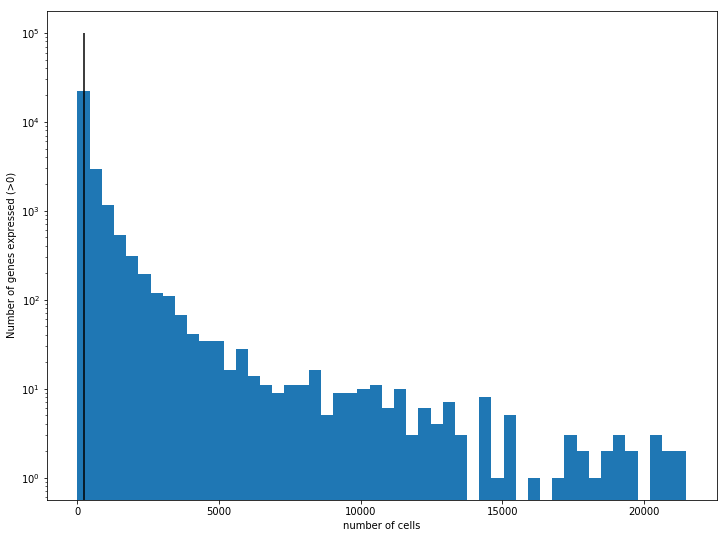

In [144]:
plt.hist(Cells_expressing, bins=50, log=True)
plt.xlabel("number of cells")
plt.ylabel("Number of genes expressed (>0)")
plt.vlines(x=1.0*nCells/100.0, ymin=0, ymax=1e5)
plt.show()

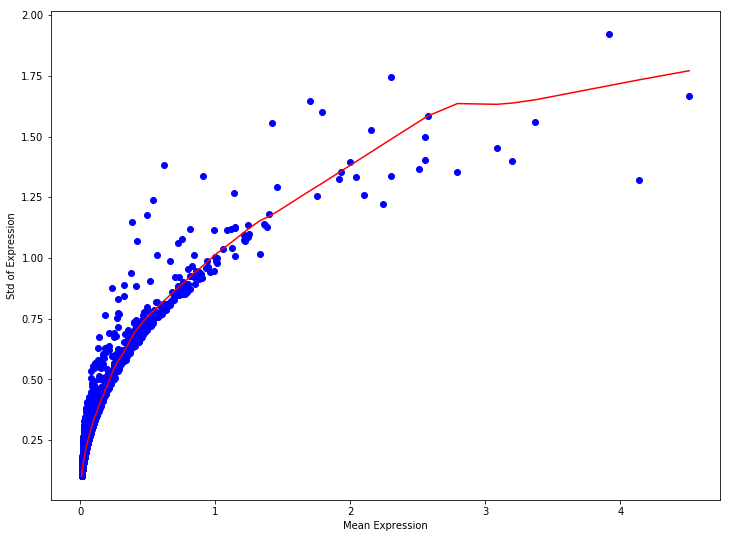

In [145]:
# Select overdispersed genes
if 'Sorted_indices' not in locals():
    Sorted_indices = np.argsort(GeneMEAN)
    
if 'Fit' not in locals():
    Fit = sm.nonparametric.lowess(GeneSD[Sorted_indices], GeneMEAN[Sorted_indices], is_sorted=True, frac = 1./100)

plt.scatter(GeneMEAN, GeneSD, color = "blue")
plt.plot(Fit[:,0], Fit[:,1], 'red')
plt.xlabel("Mean Expression")
plt.ylabel("Std of Expression")
plt.show()

In [146]:
# Show overdispersed genes
if 'OEGenes' not in locals():
    OEGenes = GeneSD[Sorted_indices] > Fit[:,1]

sum(OEGenes)

4515

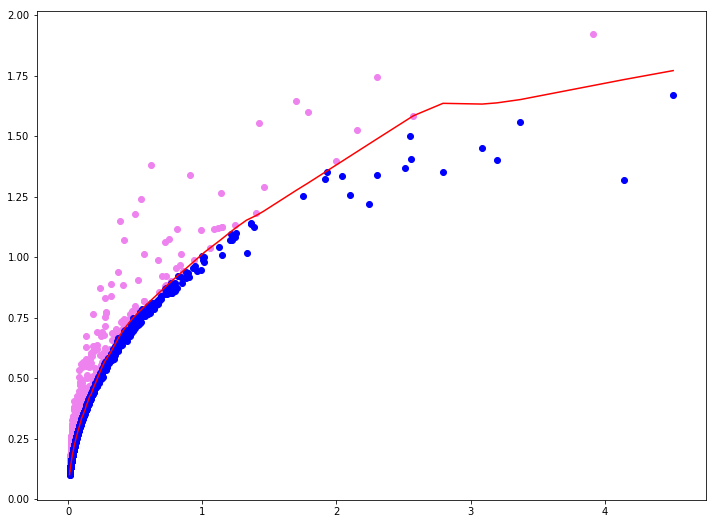

In [147]:
plt.scatter(GeneMEAN[OEGenes], GeneSD[OEGenes], color = "violet")
plt.scatter(GeneMEAN[OEGenes == False], GeneSD[OEGenes == False], color = "blue")
plt.plot(Fit[:,0], Fit[:,1], 'red')
plt.show()

In [148]:
# Obtain the filtered expression matrix

if 'Exp_norm_is_filtered' not in locals():
    Exp_norm_is_filtered = True
    Exp_norm = Exp_norm.loc[OEGenes.index[OEGenes].tolist()]

In [149]:
dill.dump_session('notebook_env.db')

In [150]:
# Export the expression matrix to a file
# Exp_norm.to_csv('FilterePlan.csv')

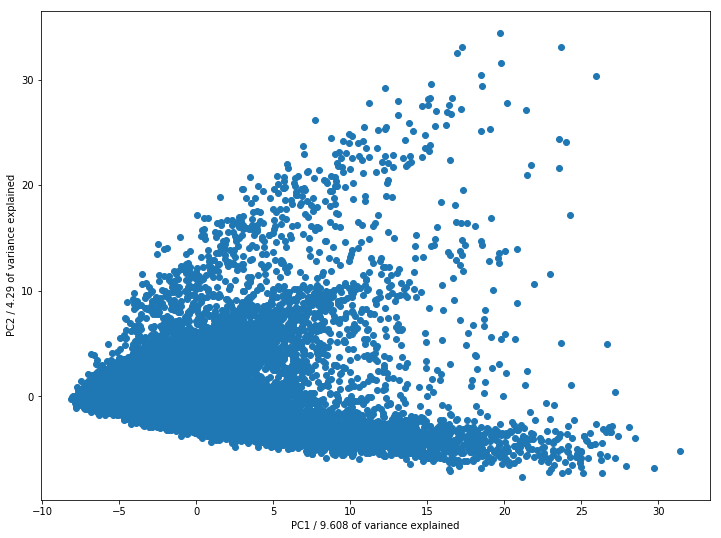

In [151]:
# Compute PCA (only 2 components will be retained) and plot the data
if 'Exp_PCA' not in locals():
    pca = sk.PCA(n_components = 2)
    pca.fit(Exp_norm.transpose())
    Exp_PCA = pca.transform(Exp_norm.transpose())
    dill.dump_session('notebook_env.db')
    
plt.scatter(Exp_PCA[:,0], Exp_PCA[:,1])
plt.xlabel("PC1 / " +
           str(np.round(pca.explained_variance_ratio_[0]*100, 3)) +
           " of variance explained")
plt.ylabel("PC2 / " +
           str(np.round(pca.explained_variance_ratio_[1]*100, 3)) +
           " of variance explained")
plt.show()

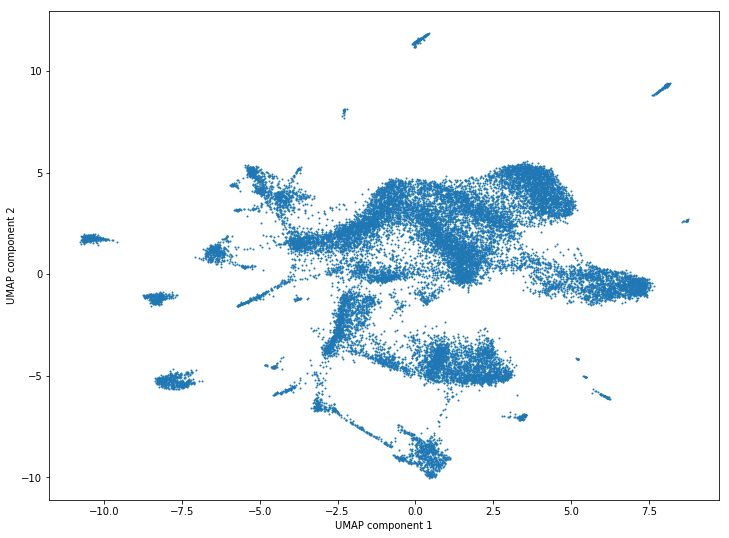

In [152]:
# Compute UMAP (only 2 components will be retained) and plot the data

if 'Exp_UMAP' not in locals():
    t0 = time.time()
    Exp_UMAP = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='correlation').fit_transform(Exp_norm.transpose())
    t1 = time.time()
    total = t1-t0
    print('Computing UMAP took', int(np.ceil(total/60)), 'minutes')
    dill.dump_session('notebook_env.db')

plt.scatter(Exp_UMAP[:,0], Exp_UMAP[:,1], s = 1)
plt.xlabel("UMAP component 1")
plt.ylabel("UMAP component 2")
plt.show()

In [153]:
# Load annotation files
Annorations = pd.DataFrame.from_csv('R_annotation.txt', sep='\t', header=None)

Annorations.shape[0] == nCells

Cell_Types = list(set(Annorations.index))
print(len(Cell_Types), "cell types detected")

51 cell types detected


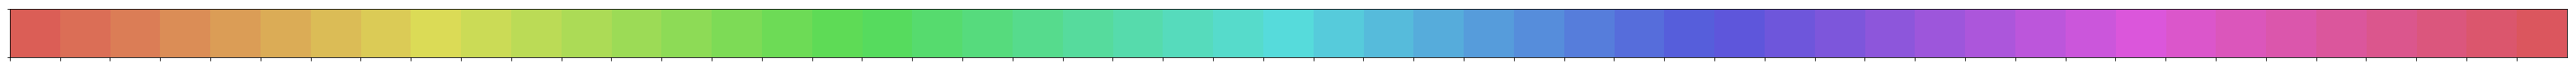

In [154]:
# Plot the palette used to differentiate between cells
Colors = sns.color_palette('hls', len(Cell_Types))
sns.palplot(Colors)
plt.show()

In [155]:
Annorations.index

Index(['secretory 1', 'secretory 1', 'secretory 1', 'psap+ parenchymal cells',
       'late epidermal progenitors 1', 'psap+ parenchymal cells', 'neoblast 1',
       'neoblast 1', 'muscle body', 'late epidermal progenitors 1',
       ...
       'neural progenitors', 'neural progenitors', 'cav-1+ neurons',
       'muscle progenitors', 'GABA neurons', 'psd+ cells',
       'late epidermal progenitors 1', 'neoblast 1', 'neoblast 6',
       'neoblast 1'],
      dtype='object', name=0, length=21612)

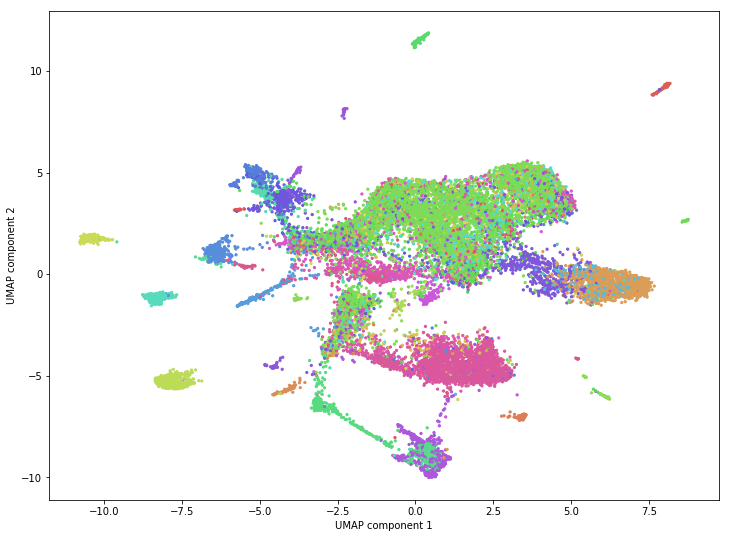

In [156]:
# Associate each cell with a color indicating its type and plot them on UMAP

Annorations['CellTypes'] = Annorations.index

CellIndices = np.zeros(nCells).astype(int)

for i in range(len(Cell_Types)):
    CellIndices[Annorations.index == Cell_Types[i]] = i
    
CellColors = [Colors[i] for i in CellIndices]
    
plt.scatter(Exp_UMAP[:,0], Exp_UMAP[:,1], color=CellColors, s=5, alpha=1)
plt.xlabel("UMAP component 1")
plt.ylabel("UMAP component 2")
plt.show()

In [157]:
# Define functions to perform separability analysis

def histc(X, bins):

    map_to_bins = np.digitize(X,bins)
    r = np.zeros((len(X[0,:]),len(bins)))
    for j in range(len(map_to_bins[0,:])):
        for i in map_to_bins[:,j]:
            r[j,i-1] += 1
    return [r, map_to_bins]

def randsphere(n_points,ndim,radius):
    center = np.array([0]*ndim)
    r = radius
    x = np.random.normal(size=(n_points, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(n_points,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p, center

def preprocessing(X, center, dimred, whiten, projectonsphere,
                  eigval_retaining_factor = 10, from_PC2 = False, Fix_Max_PC = None, ProducePlots = 1):
    Xp = X
    #centering
    nobjects = len(X[:,0])
    sampleMean = np.mean(X,axis=0)
    if center:
        Xp = X-sampleMean
    #dimension reduction
    PCAcomputed = 0
    if dimred or whiten:
        pca = sk.PCA()
        u = pca.fit_transform(Xp)
        v = pca.components_.T
        s = pca.explained_variance_
        
        if ProducePlots:
            plt.figure()
            plt.plot([x+1 for x in list(range(len(s)))], s)
            plt.xlabel('Component')
            plt.ylabel('Explained variance')
            plt.show()
        
        PCAcomputed = 1
        if from_PC2:
            sc = s/s[1]
        else:
            sc = s/s[0]
        
        ind = None
        
        if Fix_Max_PC is not None:
            ind = range(0,int(Fix_Max_PC))
            if max(ind) < 2:
                ind = None
            else:
                print('Number of components fixed by user to', ind)
        
        if ind is None:
            ind = np.where(sc > 1/eigval_retaining_factor)[0]
        
        Xp = Xp@v[:,ind]
        
        print('%i components are retained using factor %2.2f' %(len(ind),eigval_retaining_factor))
        
        if ProducePlots:
            plt.figure()
            plt.plot([x+1 for x in list(range(len(s[:len(ind)])))], s[:len(ind)])
            plt.xlabel('Component')
            plt.ylabel('Explained variance')
            plt.show()
        
    #whitening
    if whiten:
        Xp = u[:,ind]
        st = np.std(Xp,ddof=1)
        Xp = Xp/np.tile(st,(nobjects,1))
    #project on sphere (scale each vector to unit length)
    if projectonsphere:
        st = np.sqrt(np.sum(Xp**2,axis=1))
        st = np.array([st]).T
        Xp = Xp/(np.tile(st,(1,len(Xp[0,:]))))
    
    return Xp        

def probability_unseparable_sphere(alpha,n):
    p = np.power((1-alpha*alpha),(n-1)/2)/(alpha*np.sqrt(2*math.pi*n))
    return p

def checkSeparability(xy,alpha):
    dxy = np.diag(xy)
    sm = (xy/dxy).T
    sm = sm - np.diag(np.diag(sm))
    sm = sm>alpha
    py = sum(sm.T)
    py = py/len(py[0,:])
    separ_fraction = sum(py==0)/len(py[0,:])
    
    return separ_fraction,py

def checkSeparabilityMultipleAlpha(xy,alpha):

    dxy = np.diag(xy)
    sm = (xy/dxy).T

    # alpha = np.array([np.arange(.6,1,.02)])
    if len(alpha[:,0])>1:
        alpha = alpha.T
    addedone = 0
    if max(alpha[0,:])<1:
        alpha = np.array([np.append(alpha,1)])
        addedone = 1

    alpha = np.concatenate([[float('-inf')],alpha[0,:], [float('inf')]])

    sm = sm - np.diag(np.diag(sm))
    
#     sm = scipy.io.loadmat('sm.mat')['sm']

    [counts,binMap] = histc(sm.T,alpha)
    
    na=len(alpha)
    for i in range(na-1): 
        counts[:,na-i-2]=counts[:,na-i-2]+counts[:,na-i-1]
    
    py = counts/len(sm[:,0])
    py = py.T
    
    if addedone:
        py = py[1:-2,:]
    else:
        py = py[1:-1,:]
    
    separ_fraction = sum(py==0)/len(py[0,:])
    
    return separ_fraction,py

def dimension_uniform_sphere(py,alpha,number_of_data_points):
    
    if len(py)!=len(alpha[0,:]):
        print('ERROR: length of py (%i) and alpha (%i) does not match'%(len(py),len(alpha)))
        return
    
    n = np.zeros((len(alpha[0,:])))
    for i in range(len(alpha[0,:])):
        if alpha[0,i]>=1:
            print('ERROR: alpha is >=1')
            return 
        if alpha[0,i]<=0:   
            print('ERROR: alpha is <=0')
            return
        else:
            p  = py[i]
            a  = alpha[0,i]
            a2 = alpha[0,i]**2
            n[i] = lambertw(-(np.log(1-a2)/(2*math.pi*p*p*a*a*(1-a2))))/(-np.log(1-a2))
 
    n[n==np.inf]= float('nan')
    inds = np.where(~np.isnan(n))[0]
    alpha_max = max(alpha[0,inds])
    alpha_ref = alpha_max*0.9
    k = np.where(abs(alpha[0,inds]-alpha_ref)==min(abs(alpha[0,:]-alpha_ref)))[0]
    alfa_single_estimate = alpha[0,inds[k]]
    p = py[inds[k]]
    a = alfa_single_estimate
    a2 = alfa_single_estimate**2 
    print(p,a,a2)
    n_single_estimate = lambertw(-(np.log(1-a2)/(2*math.pi*p*p*a*a*(1-a2))))/(-np.log(1-a2))
    
    return n,n_single_estimate,alfa_single_estimate

def SeparabilityAnalysis(X,ColinearityControl=10,ProjectOnSphere = 1,alphas = np.array([np.arange(.6,1,.02)]),
                         ProducePlots = 1, from_PC2 = False, Fix_Max_PC = None):
    
    print('Preprocessing')
    Xp = preprocessing(X,1,1,1,ProjectOnSphere,eigval_retaining_factor=ColinearityControl,
                       from_PC2=from_PC2, ProducePlots = ProducePlots, Fix_Max_PC = Fix_Max_PC)
   
    xy = Xp@Xp.T
    npoints = len(X[:,0])
#     xy = scipy.io.loadmat('xy.mat')['xy']

    print('Checking separability')
    [separable_fraction,p_alpha] = checkSeparabilityMultipleAlpha(xy,alphas)
    py_mean = np.mean(p_alpha,axis=1)

    [n_alpha,n_single,alpha_single] = dimension_uniform_sphere(py_mean,alphas,npoints)

    alpha_ind_selected = np.where(n_single==n_alpha)[0]
    
    if ProducePlots:
        
        n_min = np.floor(min(n_alpha));
        n_max = np.floor(max(n_alpha)+0.8);
        if n_min==0:
            n_min = 1
        if n_min>1:
            n_min = n_min-1
        if n_min>1:
            n_min = n_min-1

        n_max = n_max+2
        ns = np.arange(n_min,n_max)
        
        a = alphas.copy()
        n_a = n_alpha.copy()
        n_s = n_single.copy()
        a_ind = alpha_ind_selected.copy()
        plt.figure()
        plt.plot(alphas[0,:],n_alpha,'ko-')
        plt.plot(alphas[0,alpha_ind_selected],n_single,'rx',markersize=16)
        #AlphaXTKs = plt.get_xticks()
        plt.xlabel('Alpha')
        plt.ylabel('Effective dimension')
        plt.show()
        nbins = int(round(np.floor(npoints/200)))

        if nbins<20:
            nbins = 20

        plt.figure()
        plt.hist(p_alpha[alpha_ind_selected,:][0],bins=nbins)
        plt.xlabel('unseparability prob.p for alpha=%2.2f'%(alphas[0,alpha_ind_selected]))
        plt.ylabel('Number of values')
        plt.show()

        plt.figure()
        plt.semilogy(alphas[0,:],py_mean,'bo-','LineWidth',3)
        plt.xlabel('Alpha')
        plt.ylabel('Mean unseparability prob.')
        plt.title('Theor.curves for n=%i:%i'%(n_min,n_max))

        pteor = np.zeros((len(ns),len(alphas[0,:])))
        for k in range(len(ns)):
            for j in range(len(alphas[0,:])):
                pteor[k,j] = probability_unseparable_sphere(alphas[0,j],ns[k])

        for i in range(len(pteor[:,0])):
            plt.semilogy(alphas[0,:],pteor[i,:],'-',color='r')
        plt.xlim(min(alphas[0,:]),1)
        plt.show()


    return n_alpha,n_single,p_alpha,alphas,separable_fraction

In [158]:
# Perform the analysis
if 'p_alpha' not in locals():
    [n_alpha,n_single,p_alpha,alphas,separable_fraction] = SeparabilityAnalysis(np.array(Exp_norm.transpose()))
    dill.dump_session('notebook_env.db')

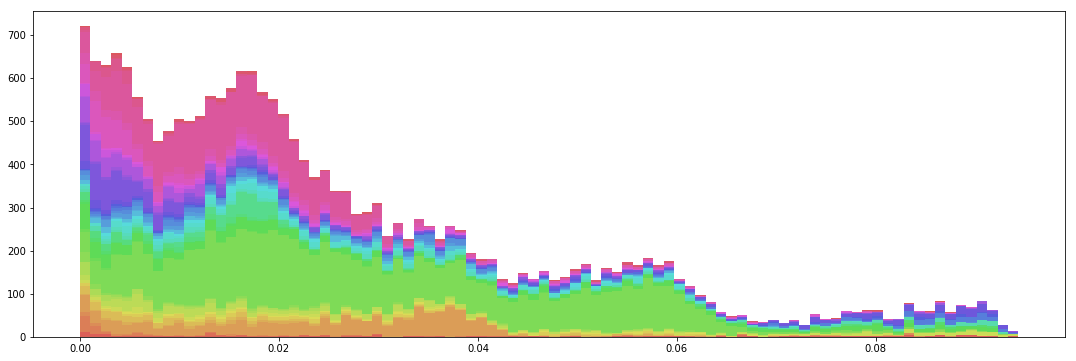

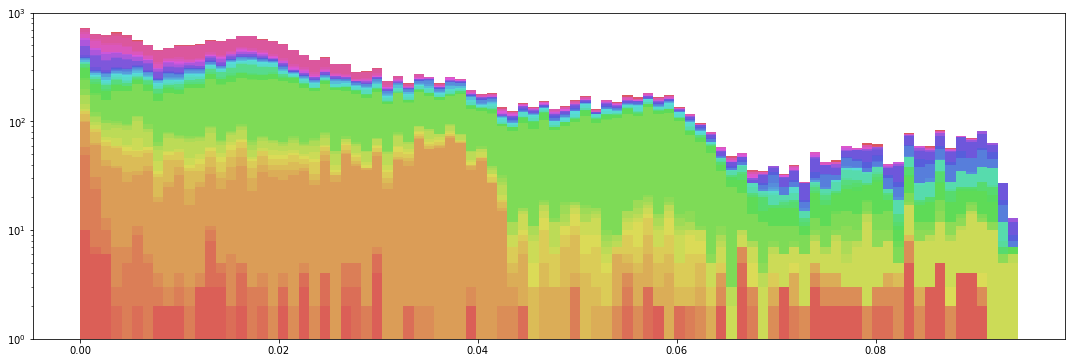

In [159]:
# Explore how cells are distributed in term of separability

SplitData = [p_alpha[15, Annorations['CellTypes'].values == cell_type] for cell_type in Cell_Types]  

Mean_p = [np.mean(p_alpha[15, Annorations['CellTypes'].values == cell_type]) for cell_type in Cell_Types]
Sd_p = [np.std(p_alpha[15, Annorations['CellTypes'].values == cell_type]) for cell_type in Cell_Types]

fig, ax = plt.subplots()
[n_A, bins_A, patches_A] = ax.hist(SplitData, bins=90, stacked=True, color=Colors)

fig.set_size_inches(18.5, 6)
plt.show()



fig, ax = plt.subplots()
[n_A, bins_A, patches_A] = ax.hist(SplitData, bins=90, stacked=True, color=Colors, density=False, log=True)

fig.set_size_inches(18.5, 6)

plt.show()

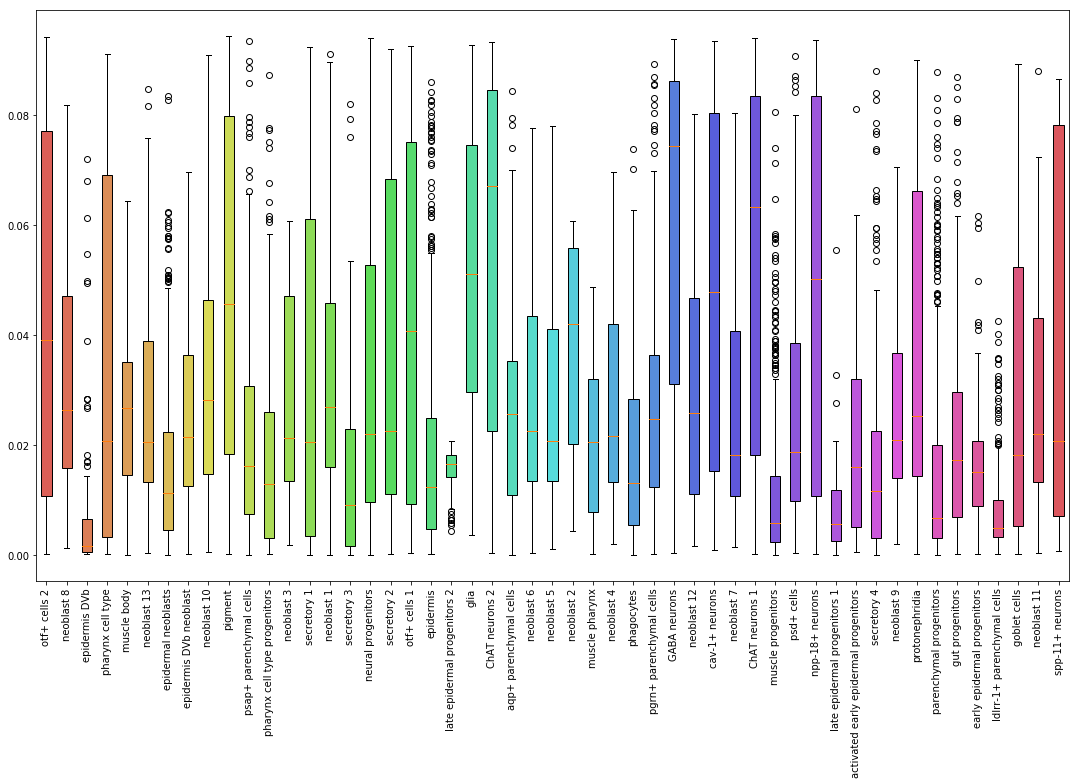

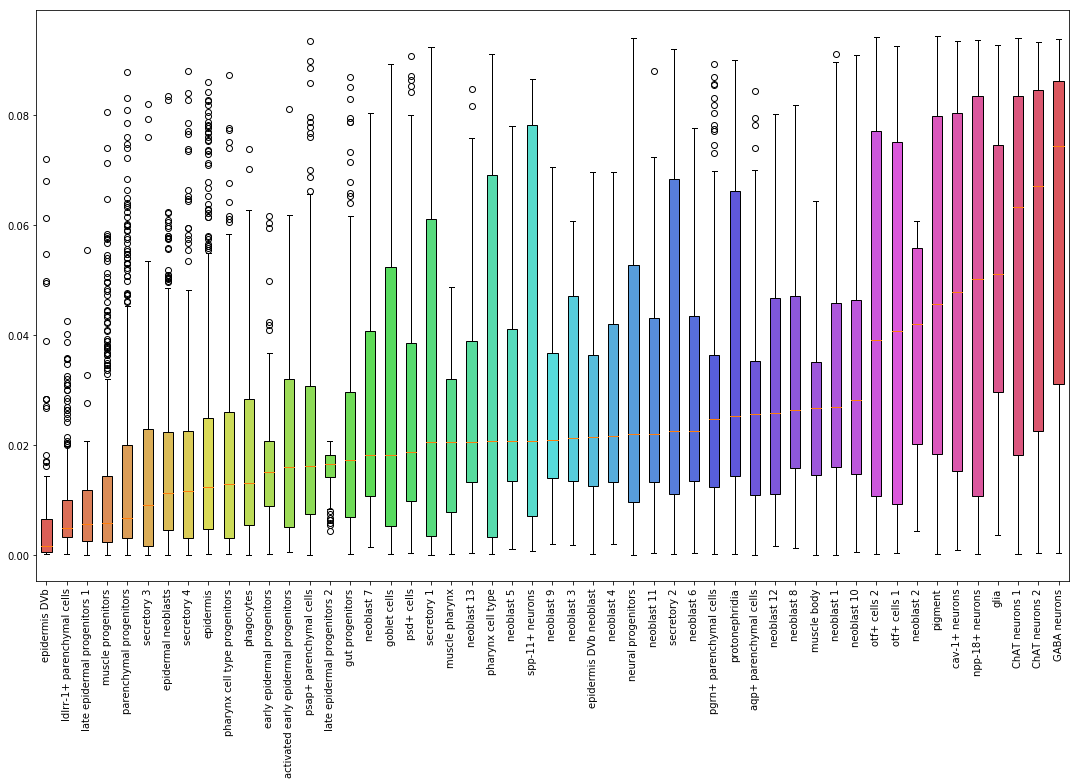

In [160]:
# Reorder groups by median deparability and plot a boxplot per cell type

MeanP = [np.median(x) for x in SplitData]
Reoerder = np.argsort(MeanP)
SplitData_Reord = [SplitData[i] for i in Reoerder]
Cell_Types_Reord = [Cell_Types[i] for i in Reoerder]

fig, ax = plt.subplots()
box = ax.boxplot(SplitData, patch_artist=True)

for patch, color in zip(box['boxes'], Colors):
    patch.set_facecolor(color)

ax.set_xticks(np.arange(len(Cell_Types))+1)
ax.set_xticklabels(Cell_Types)
plt.xticks(rotation='vertical')

fig.set_size_inches(18.5, 10.5)

plt.show()

fig, ax = plt.subplots()
box = ax.boxplot(SplitData_Reord, patch_artist=True)

for patch, color in zip(box['boxes'], Colors):
    patch.set_facecolor(color)

ax.set_xticks(np.arange(len(Cell_Types))+1)
ax.set_xticklabels(Cell_Types_Reord)
plt.xticks(rotation='vertical')

fig.set_size_inches(18.5, 10.5)

plt.show()

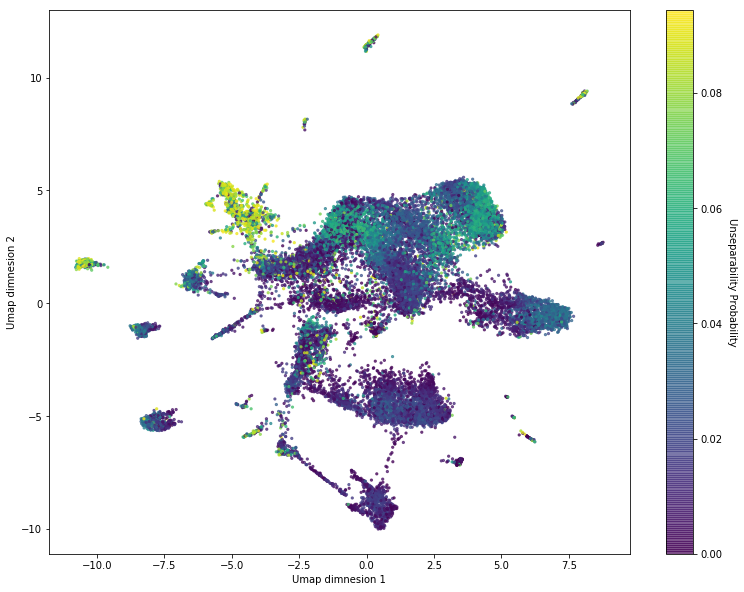

In [161]:
# Plot separability on the UMAp projection 

fig, ax = plt.subplots()
sc = ax.scatter(Exp_UMAP[:,0], Exp_UMAP[:,1], c=p_alpha[15], s = 5, alpha = .7)
cb = plt.colorbar(sc)
ax.set_xlabel("Umap dimnesion 1")
ax.set_ylabel("Umap dimnesion 2")

cb.set_label('Unseparability Probability', rotation=270)
cb.ax.get_yaxis().labelpad = 15

fig.set_size_inches(13, 10)

plt.show()

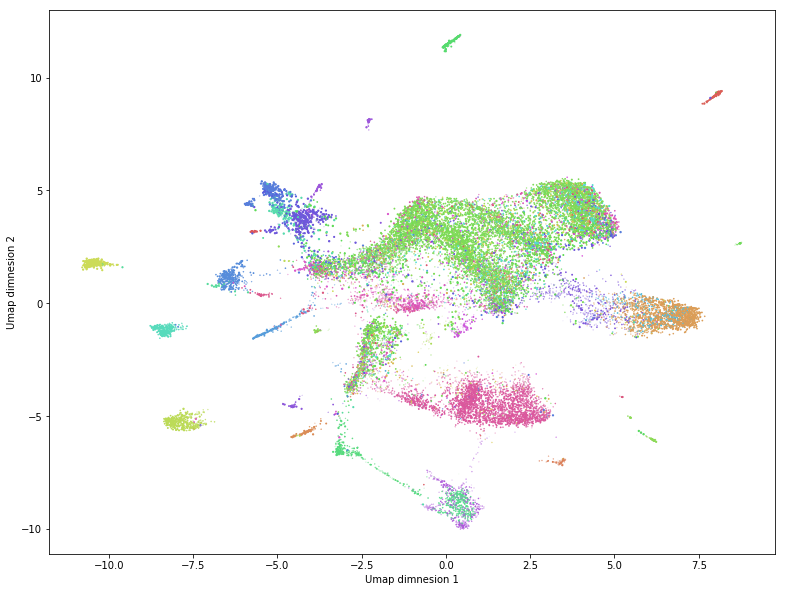

In [162]:
# Plot separability and cell type on the UMAp projection 

fig, ax = plt.subplots()
sc = ax.scatter(Exp_UMAP[:,0], Exp_UMAP[:,1], color=CellColors, s=20*p_alpha[15], alpha=1)
ax.set_xlabel("Umap dimnesion 1")
ax.set_ylabel("Umap dimnesion 2")

fig.set_size_inches(13, 10)

plt.show()

In [163]:
# Compute local dimensioanlity of different cell types separatedly

if 'AllCellTypes' not in locals():
    
    AllCellTypes = {}
    
    for ct in Cell_Types:
        print("Working on " + ct)
        if(sum(Annorations["CellTypes"].values == ct) > 20):
            [n_alpha_T,n_single_T,p_alpha_T,alphas_T,separable_fraction_T] = SeparabilityAnalysis(np.array(Exp_norm.transpose()[Annorations["CellTypes"].values == ct]),Fix_Max_PC=7, ProducePlots=0)#,alphas=alpha)
            AllCellTypes[ct] = [n_alpha_T,n_single_T,p_alpha_T,alphas_T,separable_fraction_T]
        
    dill.dump_session('notebook_env.db')

In [164]:
# And print out this inforlation

LocDim = np.zeros(len(Cell_Types))
for i in range(0, len(Cell_Types)):
    if Cell_Types[i] in AllCellTypes:
        LocDim[i] = np.real(AllCellTypes[Cell_Types[i]][1])
    else:
        LocDim[i] = np.nan

for i in range(0, len(Cell_Types)):
    print(Cell_Types[i] + " has dimension ", str(np.round(LocDim[i], 3)))

otf+ cells 2 has dimension  3.414
neoblast 8 has dimension  5.624
epidermis DVb has dimension  3.525
pharynx cell type has dimension  3.471
muscle body has dimension  4.639
neoblast 13 has dimension  4.102
epidermal neoblasts has dimension  4.81
epidermis DVb neoblast has dimension  4.42
neoblast 10 has dimension  3.17
pigment has dimension  4.294
psap+ parenchymal cells has dimension  4.782
pharynx cell type progenitors has dimension  4.165
neoblast 3 has dimension  3.901
secretory 1 has dimension  2.876
neoblast 1 has dimension  3.541
secretory 3 has dimension  3.66
neural progenitors has dimension  4.588
secretory 2 has dimension  2.638
otf+ cells 1 has dimension  3.796
epidermis has dimension  4.237
late epidermal progenitors 2 has dimension  3.799
glia has dimension  4.403
ChAT neurons 2 has dimension  4.024
aqp+ parenchymal cells has dimension  3.703
neoblast 6 has dimension  4.58
neoblast 5 has dimension  5.078
neoblast 2 has dimension  nan
muscle pharynx has dimension  4.217
ne

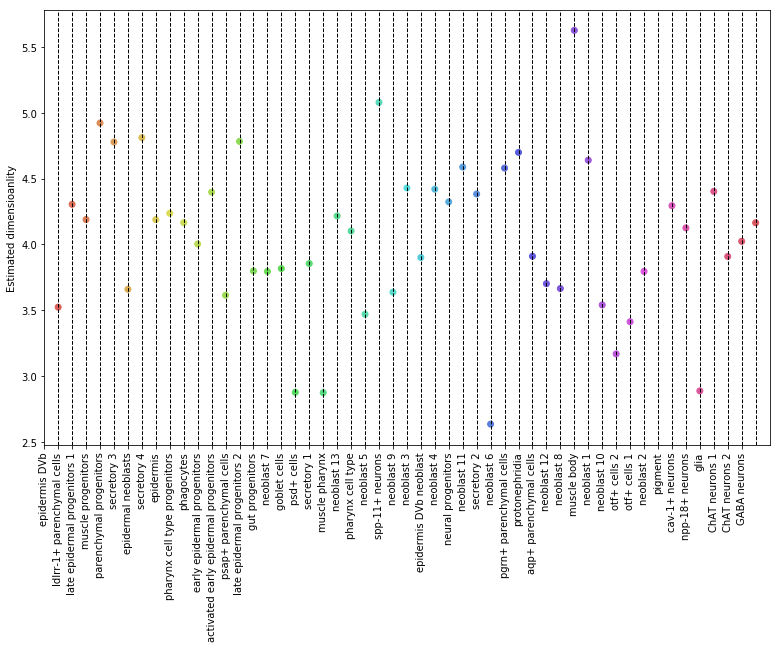

In [165]:
# Plot estimated dimensionality for each cell type

fig, ax = plt.subplots()

ax.scatter(range(1,len(LocDim)+1), LocDim[Reoerder], color = Colors)

ax.set_xticks(np.arange(len(Cell_Types)))
ax.set_xticklabels(Cell_Types_Reord)
plt.xticks(rotation='vertical')
ax.set_ylabel("Estimated dimensioanlity")

plt.xlim((0, len(Cell_Types)+1))

for i in range(1,len(LocDim)+1):
    ax.axvline(x=i, color = 'black', linestyle = '--', linewidth=1)

fig.set_size_inches(13, 8)

plt.show()

#fig, ax = plt.subplots()
#box = ax.boxplot(SplitData_Reord, patch_artist=True)

#ax.set_xticks(np.arange(len(Cell_Types))+1)
#ax.set_xticklabels(Cell_Types_Reord)
#plt.xticks(rotation='vertical')

#fig.set_size_inches(18.5, 10.5)

#plt.show()

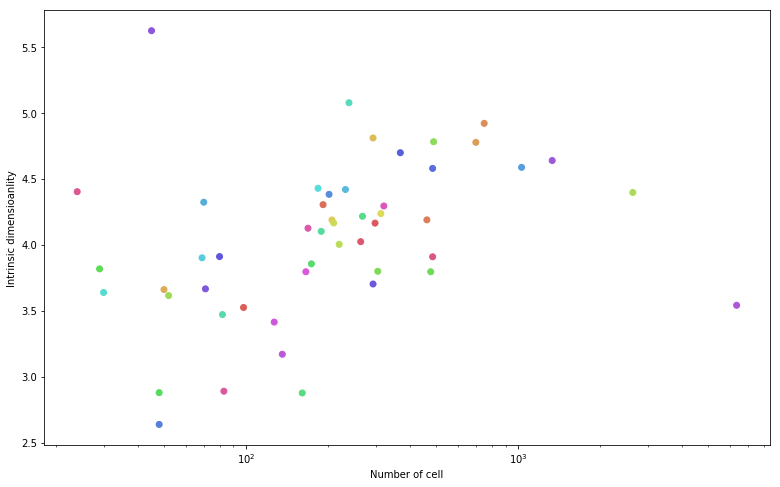

In [166]:
# Show the relation between the dimensionlity and cell number per cell type

fig, ax = plt.subplots()

ax.scatter([len(x) for x in SplitData_Reord], LocDim[Reoerder], color = Colors)
ax.set_xscale('log')

ax.set_xlabel("Number of cell")
ax.set_ylabel("Intrinsic dimensioanlity")

fig.set_size_inches(13, 8)

plt.show()

In [167]:
#And compute their correlation

np.corrcoef(np.array([len(x) for x in SplitData_Reord])[~np.isnan(LocDim[Reoerder])],
            LocDim[Reoerder][~np.isnan(LocDim[Reoerder])])

array([[1.        , 0.03689763],
       [0.03689763, 1.        ]])

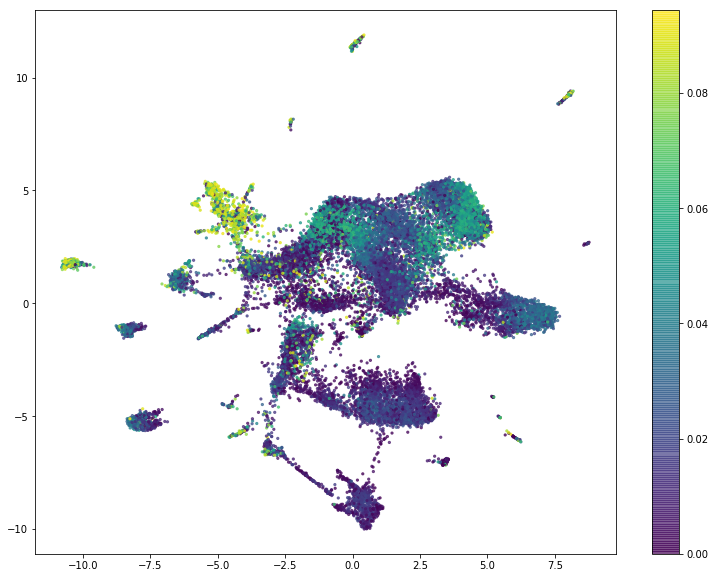

In [168]:
#Produce the figures for the article (1)

fig, ax = plt.subplots()
sc = ax.scatter(Exp_UMAP[:,0], Exp_UMAP[:,1], c=p_alpha[15], s = 5, alpha = .7)
cb = plt.colorbar(sc)
#ax.set_xlabel("Umap dimnesion 1")
#ax.set_ylabel("Umap dimnesion 2")

#cb.set_label('Unseparability Probability', rotation=270)
cb.ax.get_yaxis().labelpad = 15

fig.set_size_inches(13, 10)

plt.show()

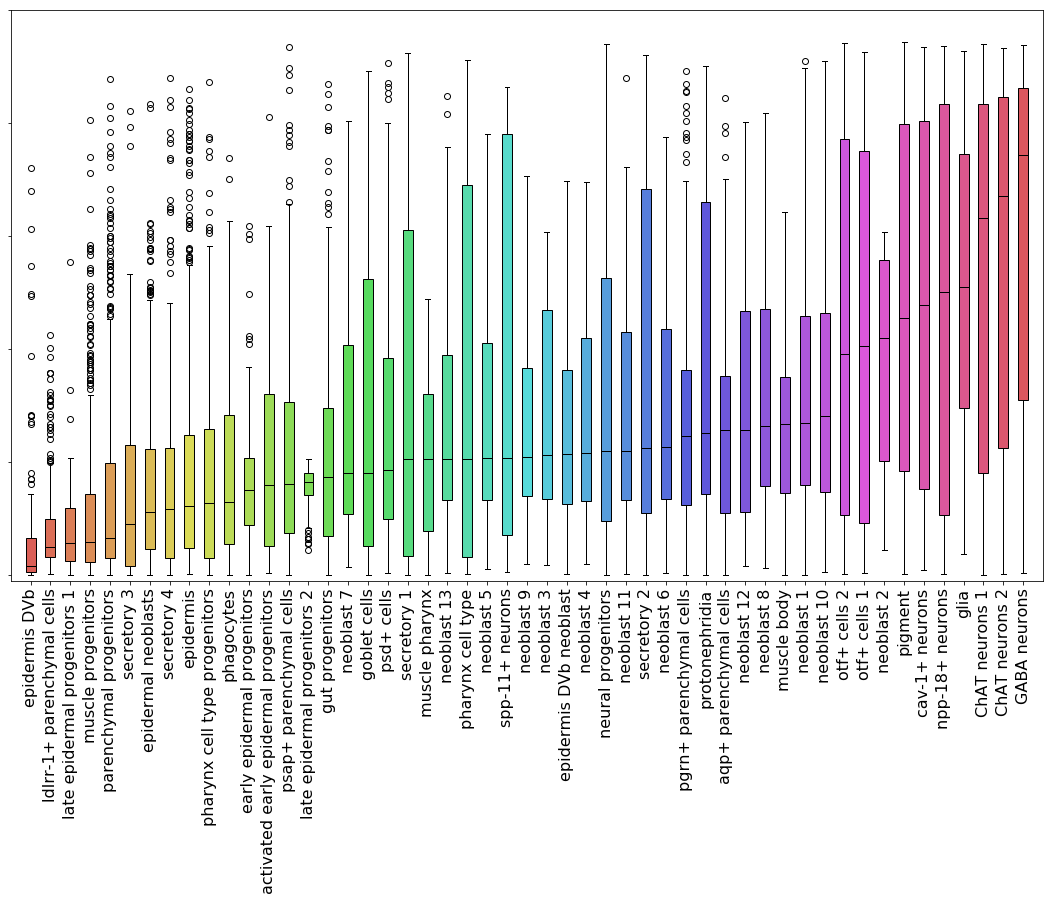

In [169]:
#Produce the figures for the article (2)

fig, ax = plt.subplots()
box = ax.boxplot(SplitData_Reord, patch_artist=True, medianprops={'color':'black'})

for patch, color in zip(box['boxes'], Colors):
    patch.set_facecolor(color)

ax.set_xticks(np.arange(len(Cell_Types))+1)
ax.set_xticklabels(Cell_Types_Reord, fontdict={'fontsize':16})
plt.xticks(rotation='vertical')
#ax.set_ylabel("Unseparability Probability")

ax.set_yticklabels('')

plt.ylim((-0.001, 0.1))
plt.xlim((0, len(Cell_Types)+1))

fig.set_size_inches(18.5, 10.5)

plt.show()

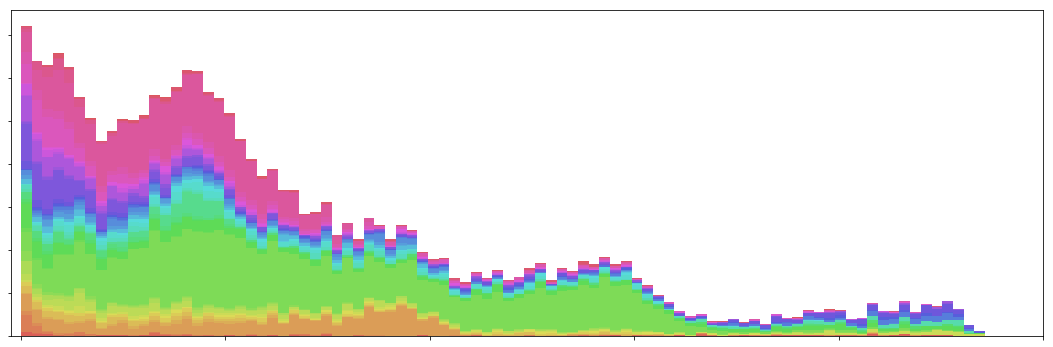

In [170]:
#Produce the figures for the article (3)

SplitData = [p_alpha[15, Annorations['CellTypes'].values == cell_type] for cell_type in Cell_Types]  

Mean_p = [np.mean(p_alpha[15, Annorations['CellTypes'].values == cell_type]) for cell_type in Cell_Types]
Sd_p = [np.std(p_alpha[15, Annorations['CellTypes'].values == cell_type]) for cell_type in Cell_Types]

#SplitData


fig, ax = plt.subplots()
[n_A, bins_A, patches_A] = ax.hist(SplitData, bins=90, stacked=True, color=Colors)

ax.set_xlabel("")
ax.set_ylabel("")
#ax.set_ylabel("Cell count")

ax.set_xticklabels('')
ax.set_yticklabels('')

plt.xlim((-0.001, 0.1))

fig.set_size_inches(18.5, 6)


#, color=CellColors, stacked=True)
plt.show()

#, Annorations['CellTypes'].values

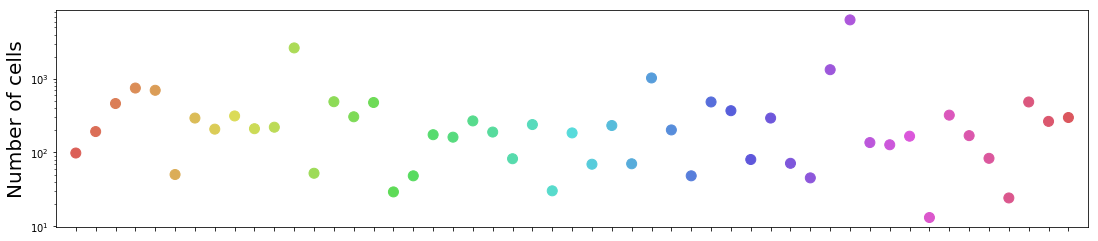

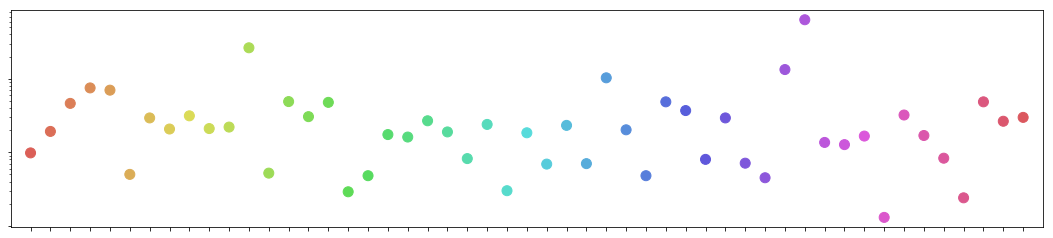

In [171]:
#Produce the figures for the article (4)






fig, ax = plt.subplots()

ax.scatter(range(1,len(LocDim)+1), [len(x) for x in SplitData_Reord], color = Colors, s= 100)

ax.set_xticks(np.arange(len(Cell_Types))+1)
ax.set_xticklabels('')
plt.xticks(rotation='vertical')
ax.set_ylabel("Number of cells", fontdict={'fontsize': 20})
ax.set_yscale('log')

plt.xlim((0, len(Cell_Types)+1))

#for i in range(0,len(LocDim)):
#    ax.axvline(x=i, color = 'black', linestyle = '--', linewidth=1)

fig.set_size_inches(18.5, 4)

plt.show()






fig, ax = plt.subplots()

ax.scatter(range(1,len(LocDim)+1), [len(x) for x in SplitData_Reord], color = Colors, s= 100)

ax.set_xticks(np.arange(len(Cell_Types))+1)
ax.set_xticklabels('')
plt.xticks(rotation='vertical')
#ax.set_ylabel("Number of cells", fontdict={'fontsize': 20})
ax.set_yscale('log')

#ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
#               10, 20, 30, 40, 50, 60, 70, 80, 90,
#               100, 200, 300, 400, 500, 600, 700, 800, 900,
#               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])

YLab = ['' for i in range(0, len(ax.get_yticks()))]
#YLab[0] = "10^0"
#YLab[9] = "10^1"
#YLab[18] = "10^2"
#YLab[27] = "10^3"

ax.set_yticklabels(labels=YLab, fontdict={'fontsize': 20})

plt.xlim((0, len(Cell_Types)+1))

#for i in range(0,len(LocDim)):
#    ax.axvline(x=i, color = 'black', linestyle = '--', linewidth=1)

fig.set_size_inches(18.5, 4)

plt.show()




In [172]:
dill.dump_session('notebook_env.db')